This notebook is intended to test the mavenn functionality which enables the computation of parameter uncertainties via inference on simulated data

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import tensorflow as tf
%matplotlib inline

#Load mavenn and check path
import mavenn

In [2]:
!rm -rf 'models/'
!mkdir 'models/'

In [3]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')
trainval_df, test_df = mavenn.split_dataset(data_df)
print(f'training + validation N: {len(trainval_df):,}')
trainval_df.head(10)

Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training + validation N: 24,405


,validation,tot_ct,ex_ct,y,x
0,False,28,2,0.023406,GGAGUGAUG
1,False,193,15,-0.074999,UUCGCGCCA
2,False,27,0,-0.438475,UAAGCUUUU
3,False,130,2,-0.631467,AUGGUCGGG
4,False,552,19,-0.433012,AGGGCAGGA
5,False,216,6,-0.482679,GGUGUCUGU
6,True,88,4,-0.241737,CAGGCAAAC
7,False,14,0,-0.167408,CAUGCAGCU
8,False,170,14,-0.048222,CAAGUCACU
9,False,242,13,-0.230795,UCCGCGCUA


In [4]:
# Get sequence length
L = len(trainval_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [5]:
# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df['y'],
               validation_flags=trainval_df['validation'],
               shuffle=True)

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.251 sec.


In [6]:
# Fit model to data
model.fit(learning_rate=.001,
          epochs=300,
          batch_size=200,
          early_stopping=True,
          early_stopping_patience=30,
          try_tqdm = True,
          linear_initialization=True,
          verbose=False)

0epoch [00:00, ?epoch/s]

Training time: 21.9 seconds


In [7]:
# # Save model
model.save('models/mpsa_ge_pairwise')

Model saved to these files:
	models/mpsa_ge_pairwise.pickle
	models/mpsa_ge_pairwise.h5


On test data:
I_var_test: 0.344 +- 0.030 bits
I_pred_test: 0.359 +- 0.013 bits


Text(0.5, 1.0, 'training hisotry')

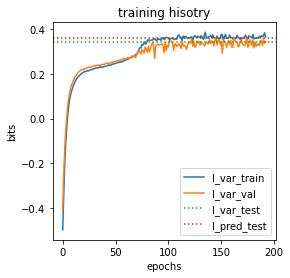

In [8]:
# Show training history
print('On test data:')

# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

# Compute variational information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

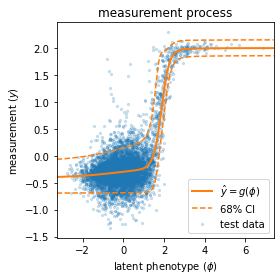

In [9]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [10]:
#uncertainty_dict = model.compute_parameter_uncertainties(num_simulations=2)
sim_models = model.sample_plausible_models(data_df=data_df,
                                           num_models=20,
                                           initialize_from_fit_model=True,)

Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 0 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.21 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 1 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.211 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.8 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 2 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.208 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.0 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 3 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.211 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.5 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 4 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.211 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.9 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 5 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.211 sec.


0epoch [00:00, ?epoch/s]

Training time: 8.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 6 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.214 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.6 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 7 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.209 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.8 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 8 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.209 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.1 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 9 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.21 sec.


0epoch [00:00, ?epoch/s]

Training time: 9.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 10 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.224 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.6 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 11 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.213 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 12 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.212 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 13 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.214 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.6 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 14 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.213 sec.


0epoch [00:00, ?epoch/s]

Training time: 8.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 15 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.212 sec.


0epoch [00:00, ?epoch/s]

Training time: 8.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 16 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.3 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 17 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.21 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.0 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 18 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.21 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.1 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 19 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.211 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.3 seconds


In [11]:
# Save models
for model_num, sim_model in enumerate(sim_models):
    sim_model.save(f'models/mpsa_ge_pairwise_sim_{model_num:02d}')

Model saved to these files:
	models/mpsa_ge_pairwise_sim_00.pickle
	models/mpsa_ge_pairwise_sim_00.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_01.pickle
	models/mpsa_ge_pairwise_sim_01.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_02.pickle
	models/mpsa_ge_pairwise_sim_02.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_03.pickle
	models/mpsa_ge_pairwise_sim_03.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_04.pickle
	models/mpsa_ge_pairwise_sim_04.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_05.pickle
	models/mpsa_ge_pairwise_sim_05.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_06.pickle
	models/mpsa_ge_pairwise_sim_06.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_07.pickle
	models/mpsa_ge_pairwise_sim_07.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_08.pickle
	models/mpsa_ge_pairwise_sim_08.h5
Model saved to these files:
	models/mpsa_ge_pairwise_sim_09.pickle
	models/mpsa_ge

In [12]:
!ls -lah models/

total 1680
drwxr-xr-x  44 jkinney  staff   1.4K Dec 27 10:34 .
drwxr-xr-x  13 jkinney  staff   416B Dec 27 10:34 ..
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:31 mpsa_ge_pairwise.h5
-rw-r--r--   1 jkinney  staff   9.1K Dec 27 10:31 mpsa_ge_pairwise.pickle
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:34 mpsa_ge_pairwise_sim_00.h5
-rw-r--r--   1 jkinney  staff   9.8K Dec 27 10:34 mpsa_ge_pairwise_sim_00.pickle
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:34 mpsa_ge_pairwise_sim_01.h5
-rw-r--r--   1 jkinney  staff    10K Dec 27 10:34 mpsa_ge_pairwise_sim_01.pickle
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:34 mpsa_ge_pairwise_sim_02.h5
-rw-r--r--   1 jkinney  staff    10K Dec 27 10:34 mpsa_ge_pairwise_sim_02.pickle
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:34 mpsa_ge_pairwise_sim_03.h5
-rw-r--r--   1 jkinney  staff    10K Dec 27 10:34 mpsa_ge_pairwise_sim_03.pickle
-rw-r--r--   1 jkinney  staff    24K Dec 27 10:34 mpsa_ge_pairwise_sim_04.h5
-rw-r--r--   1 jkinney  staff  